In [1]:
from pathlib import Path
import re
import pandas as pd
from matplotlib import colormaps
from matplotlib.colors import rgb2hex
from sklearn.preprocessing import MinMaxScaler
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt

def column_to_color(series, scale="viridis"):
    smin = series.min()
    smax = series.max()
    norm = (series - smin) / (smax - smin)
    cmap = colormaps[scale]
    return norm.apply(lambda x: rgb2hex(cmap(x)))

In [2]:
data = Path("../wintab_winit/run_output.log").read_text(encoding="UTF-16 LE")

In [3]:
print(data[2000:3100])

 lcBtnUpMask: 0b11111111111111111111111111111111,
    lcInOrgXYZ: xyz{ 0, 0, 0 },
    lcInExtXYZ: xyz{ 105370, 59270, 0 },
    lcOutOrgXYZ: xyz{ -3840, 0, 0 },
    lcOutExtXYZ: xyz{ 8960, 2160, 0 },
    lcSensXYZ: xyz{ 1fix32, 1fix32, 1fix32 },
    lcSysMode: 0,
    lcSysOrgXY: xy{ -3840, 0 },
    lcSysExtXY: xy{ 8960, 2160 },
    lcSysSensXY: xy{ 1fix32, 1fix32 },
}
============ 1
Packet {
    pkContext: 0x0000000000000014,
    pkStatus: TPS(
        0x0,
    ),
    pkTime: 86882937,
    pkChanged: WTPKT(
        STATUS | TIME | SERIAL_NUMBER | CURSOR | BUTTONS | X | Y | NORMAL_PRESSURE | ORIENTATION,
    ),
    pkSerialNumber: 5885,
    pkCursor: 1,
    pkButtons: ButtonChange {
        button_number: 0,
        change_type: NONE,
    },
    pkXYZ: xyz{ -3225, 1824, 0 },
    pkNormalPressure: 0,
    pkTangentPressure: 0,
    pkOrientation: Orientation {
        orAzimuth: 899,
        orAltitude: 740,
        orTwist: 0,
    },
    pkRotation: Rotation {
        roPitch: 0,
        r

In [4]:
matches = re.findall(
    r"Packet \{.*?\},\n\}",
    data,
    flags=re.DOTALL
)
df = pd.Series(matches)
df

0       Packet {\n    pkContext: 0x0000000000000014,\n...
1       Packet {\n    pkContext: 0x0000000000000014,\n...
2       Packet {\n    pkContext: 0x0000000000000014,\n...
3       Packet {\n    pkContext: 0x0000000000000014,\n...
4       Packet {\n    pkContext: 0x0000000000000014,\n...
                              ...                        
4825    Packet {\n    pkContext: 0x0000000000000014,\n...
4826    Packet {\n    pkContext: 0x0000000000000014,\n...
4827    Packet {\n    pkContext: 0x0000000000000014,\n...
4828    Packet {\n    pkContext: 0x0000000000000014,\n...
4829    Packet {\n    pkContext: 0x0000000000000014,\n...
Length: 4830, dtype: object

In [5]:
time = df.str.extract(f"pkTime: (.*?),", expand=False).astype("u8").rename("time")
time


0       86882937
1       86882953
2       86882953
3       86882953
4       86882953
          ...   
4825    86900546
4826    86900546
4827    86900578
4828    86900593
4829    86900593
Name: time, Length: 4830, dtype: uint64

In [6]:
xy = df.str.extract(r"xyz{ (.*?), (.*?), .*? }")
xy.columns = ["x", "y"]
xy = xy.astype("i4")
xy

,x,y
0,-3225,1824
1,-3228,1824
2,-3230,1824
3,-3233,1824
4,-3236,1823
...,...,...
4825,-2049,752
4826,-2047,747
4827,-2047,747
4828,-2047,747


In [7]:
pressure = df.str.extract(r"pkNormalPressure: (.*?),", expand=False).astype("i4").rename("pressure")
pressure

0       0
1       0
2       0
3       0
4       0
       ..
4825    0
4826    0
4827    0
4828    0
4829    0
Name: pressure, Length: 4830, dtype: int32

<Axes: xlabel='x', ylabel='y'>

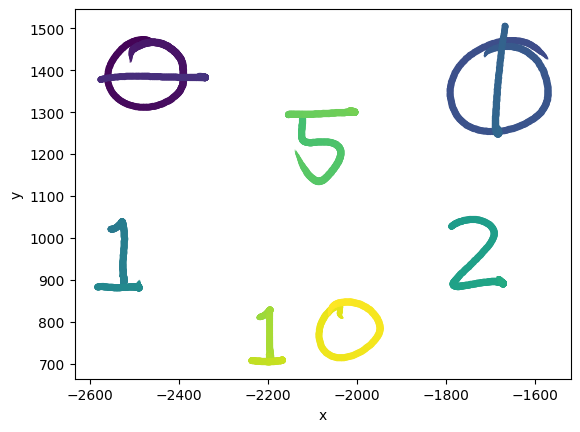

In [8]:
cdf = pd.concat([xy, time, pressure],axis="columns")
cdf=cdf[cdf["pressure"]>0]
cdf[["time","pressure"]] = MinMaxScaler().fit_transform(cdf[["time","pressure"]])
cdf.plot.scatter(x="x",y="y",c=column_to_color(cdf["time"]), s=cdf["pressure"]*20)

In [21]:
cdf = pd.concat([xy, time, pressure],axis="columns")
cdf=cdf[cdf["pressure"]>0]
cdf[["pressure"]] = MinMaxScaler().fit_transform(cdf[["pressure"]])
cdf["time"] -= cdf["time"].min()

In [22]:
cdf["time"].min(), cdf["time"].max()

(0, 9204)

In [23]:
cdf.set_index("time")

,x,y,pressure
time,,,
0,-2452,1460,0.000000
0,-2453,1461,0.016622
0,-2453,1462,0.043143
16,-2454,1463,0.076509
16,-2455,1464,0.114397
...,...,...,...
9188,-2061,825,0.155341
9188,-2061,823,0.107064
9188,-2062,821,0.065876


In [24]:
intervals = pd.interval_range(start=cdf["time"].min(), end=cdf["time"].max(), freq=10)
intervals

IntervalIndex([     (0, 10],     (10, 20],     (20, 30],     (30, 40],
                   (40, 50],     (50, 60],     (60, 70],     (70, 80],
                   (80, 90],    (90, 100],
               ...
               (9100, 9110], (9110, 9120], (9120, 9130], (9130, 9140],
               (9140, 9150], (9150, 9160], (9160, 9170], (9170, 9180],
               (9180, 9190], (9190, 9200]],
              dtype='interval[int64, right]', length=920)

In [25]:
frame_indexes = pd.Series(intervals).apply(lambda interval: cdf.index[cdf["time"].apply(lambda time: time in interval)])

Index([], dtype='int64')
Index([1773, 1774, 1775, 1776, 1777, 1778], dtype='int64')
Index([], dtype='int64')
Index([1779, 1780, 1781, 1782, 1783], dtype='int64')
Index([1784, 1785, 1786, 1787, 1788, 1789], dtype='int64')
Index([], dtype='int64')
Index([1790, 1791, 1792, 1793, 1794], dtype='int64')
Index([1795, 1796, 1797, 1798, 1799, 1800], dtype='int64')
Index([], dtype='int64')
Index([1801, 1802, 1803, 1804, 1805, 1806], dtype='int64')
Index([1807, 1808, 1809, 1810], dtype='int64')
Index([], dtype='int64')
Index([1811, 1812, 1813, 1814, 1815, 1816], dtype='int64')
Index([], dtype='int64')
Index([1817, 1818, 1819, 1820, 1821, 1822], dtype='int64')
Index([1823, 1824, 1825, 1826, 1827], dtype='int64')
Index([], dtype='int64')
Index([1828, 1829, 1830, 1831, 1832, 1833, 1834], dtype='int64')
Index([1835, 1836, 1837, 1838], dtype='int64')
Index([], dtype='int64')
Index([1839, 1840, 1841, 1842, 1843, 1844], dtype='int64')
Index([1845, 1846, 1847, 1848, 1849, 1850], dtype='int64')
Index([], 

ValueError: unknown file extension: .webm

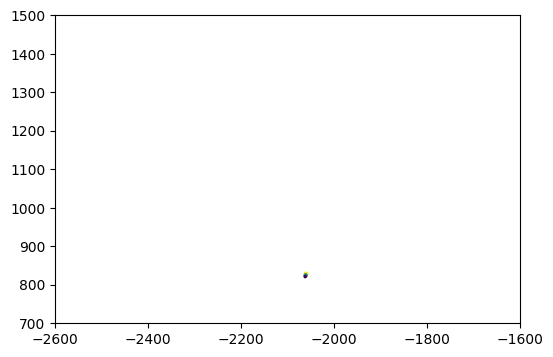

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
scatter = ax.scatter([],[], c="red")


def init():
    ax.set_xlim(-2600, -1600)
    ax.set_ylim(700, 1500)
    return scatter,


def update(frame_indexes):
    print(frame_indexes)
    if len(frame_indexes) == 0:
        return
    dat=cdf.loc[frame_indexes]
    xy = dat.loc[:,["x","y"]].values
    size = dat.loc[:,"pressure"].values*30
    color = column_to_color(dat.loc[:,"pressure"]).values
    scatter.set_offsets(xy)
    scatter.set_sizes(size)
    scatter.set_color(color)
    return scatter,

animation = FuncAnimation(
    fig       = fig,
    func      = update,
    init_func = init,
    frames    = frame_indexes,
    interval  = 5
)
animation.save("animation.gif", writer="pillow")